In [ ]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 27.49 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [ ]:
## unzip archives  q - quite, n - don't overwrite
!unzip -q -n '/content/COVID-CT/Images-processed/CT_COVID.zip'
!unzip -q -n '/content/COVID-CT/Images-processed/CT_NonCOVID.zip'

In [ ]:
import os
path='/content/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid Positive cases:  348
Covid Negative cases:  396


In [ ]:
base_dir = '/content/covid19_CT'
if not os.path.exists(base_dir): os.mkdir(base_dir)

In [ ]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):os.mkdir(test_dir)

In [ ]:
original_dataset_dir_covid = '/content/CT_COVID/'
original_dataset_dir_non_covid = '/content/CT_NonCOVID/'

import shutil
fnames = ['covid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['covid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['covid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
fnames = ['noncovid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [ ]:
def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0

In [ ]:
def createDataSplitSet(datapath):
    X=[]
    y=[]
  

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [ ]:
def increase_dataset(train_X, train_Y):
    vertical_flip = 0
    horizental_flip = 1
    for i in range(int(len(train_X)/4)):
      label = train_Y[i]
      image = cv2.flip(train_X[i], horizental_flip)
      np.append(train_X, image)
      np.append(train_Y, label)
    for i in range(int(len(train_X)/4)):
      label = train_Y[i + int(len(train_X)/4)]
      image = cv2.flip(train_X[i + int(len(train_X)/4)], vertical_flip)
      np.append(train_X, image)
      np.append(train_Y, label)
    return train_X, train_Y


In [ ]:
train_x, train_y = createDataSplitSet(train_dir)
train_X, train_Y = increase_dataset(train_x, train_y)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(len(train_X), len(train_X))

500 500


In [ ]:
## VGG 16
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
last_layer = model.get_layer('fc2').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:10]:
	layer.trainable = False

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [ ]:
history = model.fit(train_X, train_y,
                              batch_size=10,
                              epochs=100, 
                              validation_data=(val_X, val_y),
                              callbacks=my_callbacks)

Epoch 1/100
50/50 [==============================] - 9s 165ms/step - loss: 0.2640 - acc: 0.8700 - val_loss: 0.4526 - val_acc: 0.8200
Epoch 2/100
50/50 [==============================] - 9s 186ms/step - loss: 0.1459 - acc: 0.9460 - val_loss: 0.4527 - val_acc: 0.8200
Epoch 3/100
50/50 [==============================] - 8s 159ms/step - loss: 0.1404 - acc: 0.9480 - val_loss: 0.5012 - val_acc: 0.8400
Epoch 4/100
50/50 [==============================] - 8s 158ms/step - loss: 0.1395 - acc: 0.9500 - val_loss: 0.4861 - val_acc: 0.8200
Epoch 5/100
50/50 [==============================] - 8s 158ms/step - loss: 0.1377 - acc: 0.9480 - val_loss: 0.4893 - val_acc: 0.8200
Epoch 6/100
50/50 [==============================] - 8s 158ms/step - loss: 0.1366 - acc: 0.9480 - val_loss: 0.4921 - val_acc: 0.8200
Epoch 7/100
50/50 [==============================] - 8s 158ms/step - loss: 0.1366 - acc: 0.9480 - val_loss: 0.4831 - val_acc: 0.8000
Epoch 8/100
50/50 [==============================] - 8s 159ms/step - 

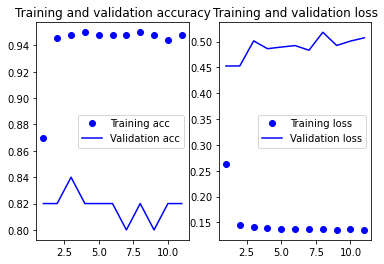

In [ ]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')
auc = roc_auc_score(test_y, ypred)
print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9480000138282776
Val Accuracy:	 0.8199999928474426
Test Accuracy:	 0.75
Precision:	 0.7608695652173914
Recall:		 0.7291666666666666
F1 Score:	 0.7446808510638298
AUC:		 0.75
